###Preprocessing

In [1]:
import pandas as pd
df = pd.read_csv('new_dbSquiggly.csv', delimiter='~')
df.head()

,Satd_type,v1_comment
0,SATD_CHANGED,TODO: Load analysis data FIXME results .csv fr...
1,SATD_REMOVED,TODO: Load analysis data FIXME results .csv fr...
2,SATD_REMOVED,FIXME: use analysis name
3,SATD_REMOVED,FIXME:
4,SATD_REMOVED,TODO: sort func must be independent of param i...


In [2]:
df = df[pd.notnull(df['v1_comment'])]

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 729 entries, 0 to 728
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Satd_type   729 non-null    object
 1   v1_comment  729 non-null    object
dtypes: object(2)
memory usage: 17.1+ KB


In [4]:
col = ['Satd_type', 'v1_comment']
df = df[col]

In [5]:
df.columns

Index(['Satd_type', 'v1_comment'], dtype='object')

In [6]:
df.columns = ['Satd_type', 'v1_comment']

In [7]:
df['category_id'] = df['Satd_type'].factorize()[0]
from io import StringIO
category_id_df = df[['Satd_type', 'category_id']].drop_duplicates().sort_values('category_id') #Removing duplicates
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Satd_type']].values) #Converting datd_type to categorical data
id_to_category

{0: 'SATD_CHANGED',
 1: 'SATD_REMOVED',
 2: 'CLASS_OR_METHOD_CHANGED',
 3: 'FILE_PATH_CHANGED',
 4: 'SATD_MOVED_FILE'}

In [8]:
count = 0
for a in df.v1_comment:
  if len(a.split()) < 4: #Finding all the data which has fewer than 4 words 
    count += 1
count

99

In [9]:
! pip install langid

In [10]:
import langid
count = 0
for a in df.v1_comment:
  if len(a.split()) > 3 and langid.classify(a)[0] == 'en': #Finding all the data which has more than 3 words and also is english
    count += 1
count

582

In [11]:
df = df[[(len(x.split()) > 3 and langid.classify(x)[0] == 'en') for x in df['v1_comment']]]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 582 entries, 0 to 728
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Satd_type    582 non-null    object
 1   v1_comment   582 non-null    object
 2   category_id  582 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 18.2+ KB


In [12]:
# df = df.drop_duplicates()
df = df.reset_index(drop=True) #Resetting the index

In [13]:
df.head()

,Satd_type,v1_comment,category_id
0,SATD_CHANGED,TODO: Load analysis data FIXME results .csv fr...,0
1,SATD_REMOVED,TODO: Load analysis data FIXME results .csv fr...,1
2,SATD_REMOVED,FIXME: use analysis name,1
3,SATD_REMOVED,TODO: sort func must be independent of param i...,1
4,SATD_REMOVED,TODO order by sum tag,1


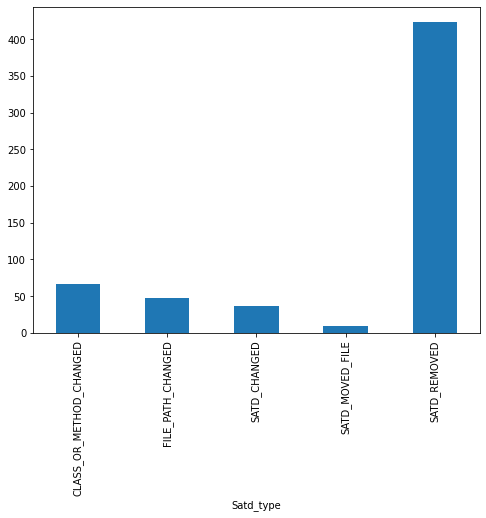

In [14]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('Satd_type').v1_comment.count().plot.bar(ylim=0)
plt.show()

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

features = tfidf.fit_transform(df.v1_comment).toarray()
labels = df.category_id
features.shape

(582, 251)

In [16]:
from sklearn.feature_selection import chi2
import numpy as np

N = 2
for Satd_type, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(Satd_type))
  print("  . Most correlated unigrams:\n       . {}".format('\n       . '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n       . {}".format('\n       . '.join(bigrams[-N:])))

# 'CLASS_OR_METHOD_CHANGED':
  . Most correlated unigrams:
       . extract
       . swimming
  . Most correlated bigrams:
       . plexus utils
       . swimming pool
# 'FILE_PATH_CHANGED':
  . Most correlated unigrams:
       . fix
       . exception
  . Most correlated bigrams:
       . todo need
       . todo filter
# 'SATD_CHANGED':
  . Most correlated unigrams:
       . final
       . file
  . Most correlated bigrams:
       . mime type
       . shouldnt archiver
# 'SATD_MOVED_FILE':
  . Most correlated unigrams:
       . idea
       . determine
  . Most correlated bigrams:
       . ll need
       . todo gm
# 'SATD_REMOVED':
  . Most correlated unigrams:
       . good
       . swimming
  . Most correlated bigrams:
       . todo filter
       . swimming pool


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is d

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(df['v1_comment'], df['Satd_type'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

clf = MultinomialNB().fit(X_train_tfidf, y_train)

###Model Selection

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
import numpy as np

from sklearn.model_selection import cross_val_score


models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
predic = []
for model in models:
  model.fit(features, labels)
  predic.append(model.predict(features))
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='f1_weighted', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'f1_weighted'])

In [19]:
from statsmodels.stats.contingency_tables import cochrans_q, mcnemar

def checkIfBestModel(contTables):
  for i in range(3):
    result = mcnemar(contTables[i], exact=True)
    # summarize the finding
    print('statistic=%.3f, p-value=%.3f' % (result.statistic, result.pvalue))
    # interpret the p-value
    alpha = 0.05
    if result.pvalue > alpha:
      print(f"tied with model: {i}")
      return False
  return True

dfRes = pd.DataFrame({'labels': labels, 'first': predic[0],'second': predic[1], 'third': predic[2], 'fourth': predic[3]})

print(cochrans_q(dfRes))

contTables = []

for i in range(4):
  for j in range(i+1, 4):
    currTable = [[0,0],[0,0]]
    for index, row in dfRes.iterrows():
      if row[i+1] == row[j+1] == row[0]:
        currTable[0][0] += 1
      elif row[i+1] != row[0] and row[j+1] != row[0]:
        currTable[1][1] += 1
      elif row[i+1] == row[0] and row[j+1] != row[0]:
        currTable[0][1] += 1
      else:
        currTable[1][0] += 1
    contTables.append(currTable)

print(contTables)
print()
print(f"Check if the first model (random forest) is our best model, without tieing with any other model: {checkIfBestModel(contTables)}")
print("there is a tie between the first model (random forest) and the second model (Linear SVC), so pick the one with the higher f1-score (random forest):")
print()
print("so Random Forest is our best model")

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


df          4
pvalue      8.88067561120273e-06
statistic   28.727272727272727
[[[415, 8], [52, 107]], [[419, 4], [8, 151]], [[422, 1], [9, 150]], [[419, 48], [8, 107]], [[424, 43], [7, 108]], [[425, 2], [6, 149]]]

statistic=8.000, p-value=0.000
statistic=4.000, p-value=0.388
tied with model: 1
Check if the first model (random forest) is our best model, without tieing with any other model: False
there is a tie between the first model (random forest) and the second model (Linear SVC), so pick the one with the higher f1-score (random forest):

so Random Forest is our best model


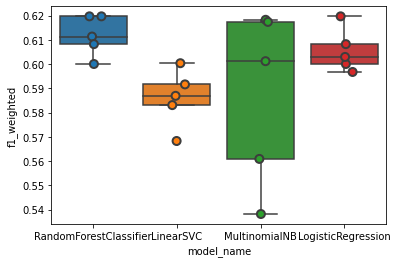

In [20]:
import seaborn as sns

sns.boxplot(x='model_name', y='f1_weighted', data=cv_df)
sns.stripplot(x='model_name', y='f1_weighted', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [21]:
cv_df.groupby('model_name').f1_weighted.mean()

model_name
LinearSVC                 0.586080
LogisticRegression        0.605575
MultinomialNB             0.587213
RandomForestClassifier    0.611850
Name: f1_weighted, dtype: float64

###Before tuning the selected model

In [22]:
from sklearn.model_selection import StratifiedShuffleSplit
#Spliting dataset using stratisfiedshufflesplit
sss = StratifiedShuffleSplit(test_size=0.20,random_state=42,n_splits=1)
X_train, X_test, y_train, y_test = (None, None, None, None)
for train_index, test_index in sss.split(features,labels):
    X_train, X_test = features[train_index], features[test_index]
    y_train, y_test = labels[train_index], labels[test_index]

In [23]:
from sklearn.model_selection import train_test_split

model = RandomForestClassifier(n_estimators=200, max_depth=50, random_state=0)

# X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.20, random_state=1)

In [24]:
from imblearn.over_sampling import SMOTE, ADASYN,RandomOverSampler
from imblearn.combine import SMOTETomek
from collections import Counter

counter = Counter(y_train)
print("before: ",counter)
smote = SMOTE(random_state=42)
X_train,y_train = smote.fit_resample(X_train,y_train)
counter = Counter(y_train)
print("after: ",counter)

before:  Counter({1: 338, 2: 53, 3: 38, 0: 29, 4: 7})
after:  Counter({1: 338, 0: 338, 3: 338, 2: 338, 4: 338})


In [25]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

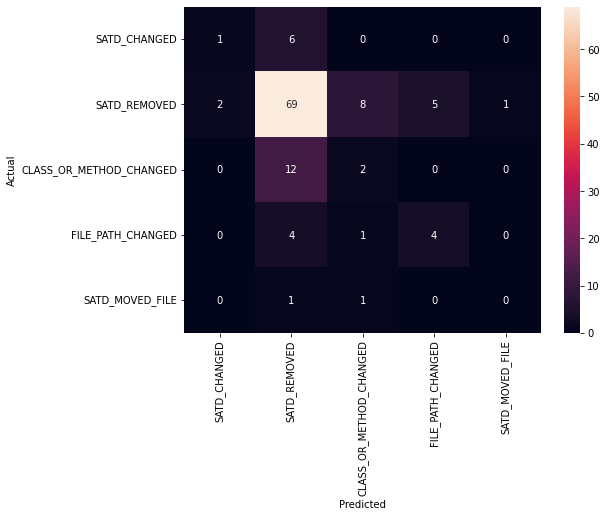

In [26]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Satd_type.values, yticklabels=category_id_df.Satd_type.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [27]:
# from IPython.display import display

# for predicted in category_id_df.category_id:
#   for actual in category_id_df.category_id:
#     if predicted != actual and conf_mat[actual, predicted] >= 6:
#       print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
#       display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['Satd_type', 'v1_comment']])
#       print('')

In [28]:
texts = ["FIXME throw assertion exception if constraintValidatorType == null",
         "TODO order by sum tag",
         "TODO remove the part with ToolchainManager lookup once we depend on 3.0.9 (have it as prerequisite). Define as regular component field then."]
         
text_features = tfidf.transform(texts)
predictions = model.predict(text_features)
for text, predicted in zip(texts, predictions):
  print('"{}"'.format(text))
  print("  - Predicted as: '{}'".format(id_to_category[predicted]))
  print("")

"FIXME throw assertion exception if constraintValidatorType == null"
  - Predicted as: 'FILE_PATH_CHANGED'

"TODO order by sum tag"
  - Predicted as: 'SATD_REMOVED'

"TODO remove the part with ToolchainManager lookup once we depend on 3.0.9 (have it as prerequisite). Define as regular component field then."
  - Predicted as: 'SATD_REMOVED'



In [29]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, 
                                    target_names=df['Satd_type'].unique()))

                         precision    recall  f1-score   support

           SATD_CHANGED       0.33      0.14      0.20         7
           SATD_REMOVED       0.75      0.81      0.78        85
CLASS_OR_METHOD_CHANGED       0.17      0.14      0.15        14
        SATD_MOVED_FILE       0.44      0.44      0.44         9
      FILE_PATH_CHANGED       0.00      0.00      0.00         2

               accuracy                           0.65       117
              macro avg       0.34      0.31      0.32       117
           weighted avg       0.62      0.65      0.63       117



#Hyperparameter Tuning

In [30]:
"""
  creating a grid for gridsearch model_selection to run on
"""

bootstrap = [True,False]
criterion = ['gini','entropy']
max_depth = [int(x) for x in range(0,111,10)]
max_depth[0] = 'None'
min_samples_split = [int(x) for x in range(2,52,2)]
max_leaf_nodes = [int(x) for x in range(0,115,15)]
max_leaf_nodes[0] = 'None'
min_samples_leaf = [int(x) for x in range(1,251,10)]
n_estimators = [int(x) for x in range(1,501,20)]

In [31]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'bootstrap' : bootstrap,
    'criterion' : criterion,
    'max_depth' : max_depth,
    'min_samples_split' : min_samples_split,
    'max_leaf_nodes' : max_leaf_nodes,
    'min_samples_leaf' : min_samples_leaf,
    'n_estimators' : n_estimators
}

rf = RandomForestClassifier(n_estimators=200,max_depth=3,random_state=0)
# base_model = rf
# base_model.fit(X_train,y_train)
# base_acc = base_model.score(X_test,y_test)
# print(base_acc)

In [50]:
# g_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv = 3, n_jobs=1, verbose=2) #Ran the tuning on cluster as colab doesnt allow more than 3 hours of computational in background
# g_search.fit(X_train,y_train)

In [51]:
# g_search.best_params_

In [32]:
def show_plot(train_score,test_score,parameter,name):
  plt.plot(parameter,train_score,'g',label="Train_Score")
  plt.plot(parameter,test_score,'r',label="Test_Score")
  plt.legend()
  plt.title(name)
  plt.show()

In [33]:
train_score = []
test_score = []

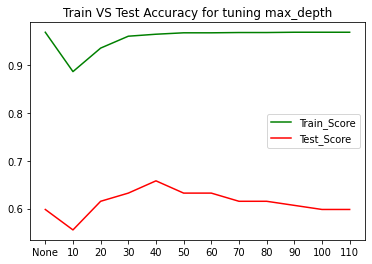

In [34]:
train_score = []
test_score = []
rf = RandomForestClassifier(random_state=0)
for i in max_depth:
  if i != "None":
    rf.set_params(max_depth = i)
  rf.fit(X_train,y_train)
  train_score.append(rf.score(X_train,y_train))
  test_score.append(rf.score(X_test,y_test))
show_plot(train_score,test_score,max_depth,"Train VS Test Accuracy for tuning max_depth")

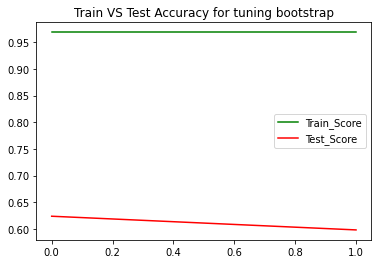

In [35]:
train_score = []
test_score = []
rf = RandomForestClassifier(random_state=0)
for i in bootstrap:
  if i != "None":
    rf.set_params(bootstrap = i)
  rf.fit(X_train,y_train)
  train_score.append(rf.score(X_train,y_train))
  test_score.append(rf.score(X_test,y_test))
show_plot(train_score,test_score,bootstrap,"Train VS Test Accuracy for tuning bootstrap")

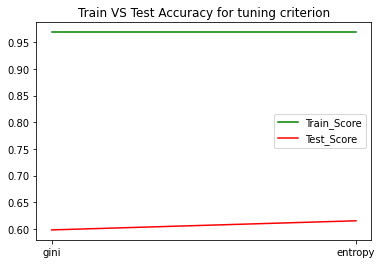

In [36]:
train_score = []
test_score = []
rf = RandomForestClassifier(random_state=0)
for i in criterion:
  if i != "None":
    rf.set_params(criterion = i)
  rf.fit(X_train,y_train)
  train_score.append(rf.score(X_train,y_train))
  test_score.append(rf.score(X_test,y_test))
show_plot(train_score,test_score,criterion,"Train VS Test Accuracy for tuning criterion")

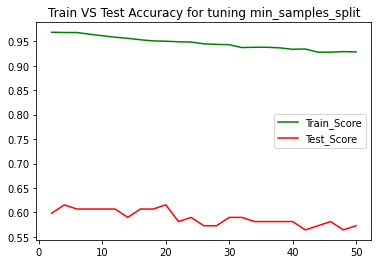

In [37]:
train_score = []
test_score = []
rf = RandomForestClassifier(random_state=0)
for i in min_samples_split:
  if i != "None":
    rf.set_params(min_samples_split = i)
  rf.fit(X_train,y_train)
  train_score.append(rf.score(X_train,y_train))
  test_score.append(rf.score(X_test,y_test))
show_plot(train_score,test_score,min_samples_split,"Train VS Test Accuracy for tuning min_samples_split")

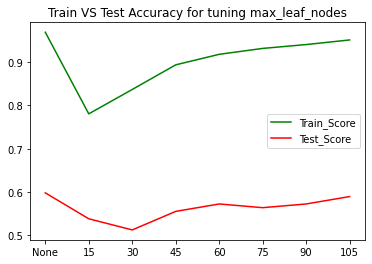

In [38]:
train_score = []
test_score = []
rf = RandomForestClassifier(random_state=0)
for i in max_leaf_nodes:
  if i != "None":
    rf.set_params(max_leaf_nodes = i)
  rf.fit(X_train,y_train)
  train_score.append(rf.score(X_train,y_train))
  test_score.append(rf.score(X_test,y_test))
show_plot(train_score,test_score,max_leaf_nodes,"Train VS Test Accuracy for tuning max_leaf_nodes")

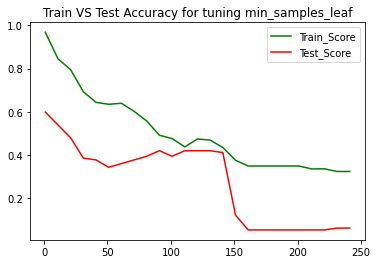

In [39]:
train_score = []
test_score = []
rf = RandomForestClassifier(random_state=0)
for i in min_samples_leaf:
  if i != "None":
    rf.set_params(min_samples_leaf = i)
  rf.fit(X_train,y_train)
  train_score.append(rf.score(X_train,y_train))
  test_score.append(rf.score(X_test,y_test))
show_plot(train_score,test_score,min_samples_leaf,"Train VS Test Accuracy for tuning min_samples_leaf")

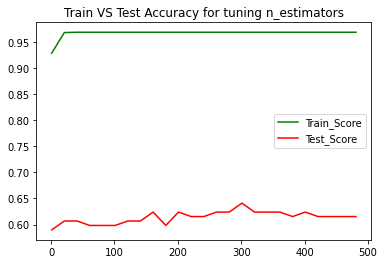

In [40]:
train_score = []
test_score = []
rf = RandomForestClassifier(random_state=0)
for i in n_estimators:
  if i != "None":
    rf.set_params(n_estimators = i)
  rf.fit(X_train,y_train)
  train_score.append(rf.score(X_train,y_train))
  test_score.append(rf.score(X_test,y_test))
show_plot(train_score,test_score,n_estimators,"Train VS Test Accuracy for tuning n_estimators")

In [41]:
best_model = RandomForestClassifier(bootstrap=False,criterion='entropy',n_estimators=200,max_depth=40,random_state=0) #After tuning the model this are the best parameter

In [42]:
best_model.fit(X_train,y_train)

RandomForestClassifier(bootstrap=False, criterion='entropy', max_depth=40,
                       n_estimators=200, random_state=0)

In [43]:
train_yhat = best_model.predict(X_train)

In [44]:
from sklearn.metrics import accuracy_score
accuracy_score(y_train,train_yhat)

0.9668639053254438

In [45]:
y_pred = best_model.predict(X_test)
accuracy_score(y_test,y_pred)

0.6324786324786325

In [46]:
CV = 5
cv_df = pd.DataFrame(index=range(CV))
entries = []
model_name = best_model.__class__.__name__
accuracies = cross_val_score(best_model, features, labels, scoring='f1_weighted', cv=CV)
for fold_idx, f1_weighted in enumerate(accuracies):
  entries.append((model_name, fold_idx, f1_weighted))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'f1_weighted'])

In [47]:
cv_df.groupby('model_name').f1_weighted.mean()

model_name
RandomForestClassifier    0.575336
Name: f1_weighted, dtype: float64

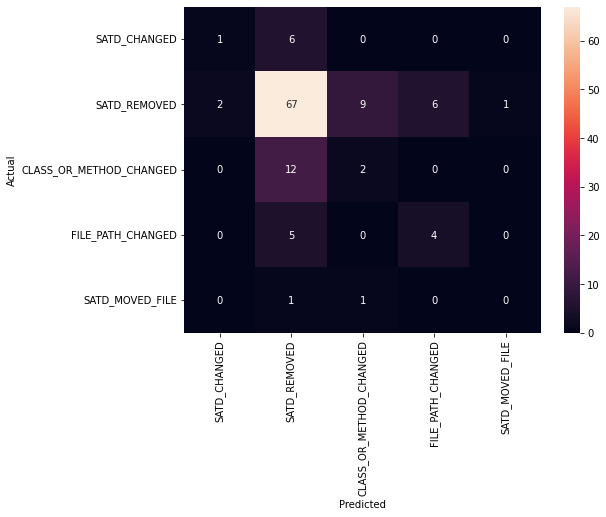

In [48]:
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Satd_type.values, yticklabels=category_id_df.Satd_type.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [49]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, 
                                    target_names=df['Satd_type'].unique())) #Final result of model

                         precision    recall  f1-score   support

           SATD_CHANGED       0.33      0.14      0.20         7
           SATD_REMOVED       0.74      0.79      0.76        85
CLASS_OR_METHOD_CHANGED       0.17      0.14      0.15        14
        SATD_MOVED_FILE       0.40      0.44      0.42         9
      FILE_PATH_CHANGED       0.00      0.00      0.00         2

               accuracy                           0.63       117
              macro avg       0.33      0.30      0.31       117
           weighted avg       0.61      0.63      0.62       117

